In [29]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [30]:
data = pd.read_csv("Downloads/hackathon_data_encrypted.csv",delimiter=";")

In [31]:
data.index = data['ID']
data = data.drop('ID',axis=1)

In [32]:
for cid in set(data['DISTRICT']):
    print(len(data.ix[data['DISTRICT']==cid,:]))

344
430
258
430
430


In [33]:
def parse_date (string):
    spl = re.split('-', string)
    spl = map( lambda x: int(x), spl)
    return {'year': spl[0] , 'month': spl[1], 'day': spl[2]}

In [34]:
parse_date('2015-02-01')

{'day': 1, 'month': 2, 'year': 2015}

In [35]:
dates = pd.DataFrame(map(parse_date, data['SUNDAY_DATE']))
data = pd.concat([data, dates], axis=1)
#data = data.drop("SUNDAY_DATE",axis=1)

In [36]:
aggvis = data.groupby("SUNDAY_DATE").sum()['VISITS']
aggvis = pd.DataFrame(aggvis)
dates = pd.DataFrame(map(parse_date, aggvis.index))
aggvis['number'] = 32*np.array(dates['month']) + np.array(dates['day']) + 400*(np.array(dates['year'])-2015)
aggvis['year'] = np.array(dates['year'])
aggvis = aggvis.sort_values(by='number')
aggvis = aggvis.reset_index()
aggvis['number'] = aggvis.index

In [37]:
aggvis_2015 = aggvis.ix[aggvis['year']==2015,:].drop('year',axis=1)
aggvis_2016 = aggvis.ix[aggvis['year']==2016,:].drop('year',axis=1)

In [38]:
for date in set(data['SUNDAY_DATE']):
    data.ix[data['SUNDAY_DATE'] == date,'number'] = int(aggvis.ix[aggvis['SUNDAY_DATE'] == date,:].index[0])
data['number'] = map(int, data['number'])

In [39]:
visits = np.zeros(dtype='float32',shape=(22,len(set(data['number']))))
for i in np.sort(list(set(data['CLINIC_ID']))):
    arr = np.array(data.ix[data['CLINIC_ID']==i, ['number','VISITS']], dtype='float32')
    for j in range(np.shape(arr)[0]):
        visits[i-1,int(arr[j,0])] = arr[j,1].copy()
        #CLINIC_ID начинаются с единицы!!

In [40]:
from math import cos,pi
from random import random
from scipy.optimize import fmin,basinhopping,fmin_bfgs

trend_and_seas = np.zeros(shape=(22,len(set(data['number']))),dtype='float32')
#for cid in range(len(visits)):
for cid in range(2,3):
    def f (x, li):
        li = li[:]
        a = li[0]
        li = li[1:]
        tau,a0 = li[0:2]
        summ = a0/2
        tau = 52
        k = 1
        while True:
            try:
                li = li[2:]
                summ += li[0]*cos(2*pi*k*x/tau + li[1])
                k += 1
            except:
                break
        return summ + a*x*0
    
    def loss(li) :
        def fx (x):
            return f(x,li)
        preds = map(fx, np.arange(len(set(data['number']))))
        preds = np.array(preds,dtype='float32')
        res = np.mean(np.square(preds-visits[cid]))
        return res
    
    li = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    for i in range(len(li)):
        if i == 0:
            li[i] = 30
        else:
            li[i] = 100*random() + 1200
    
    delta = 0.09
    step = 0.03
    moment1 = 0.1
    moment = [0,0,0,0,0,0]
#    for i in range(20000):
#        for j in range(len(li)):
#            b = li[:]
#            b[j] += delta
#            if j==0:
#                moment1 = 0.0006*(loss(b)-loss(li))/delta + 0.1*moment1
#                li[j] -= moment1
#            else:
#                moment[j-1] = step*(loss(b)-loss(li))/delta + 0.1*moment[j-1]
#                li[j] -= moment[j-1]
    ma = 100000000000000
    for h in range(40):
        for i in range(len(li)):
            if i == 0:
                li[i] = 30
            else:
                li[i] = 200*random() + 1200
        
        li = fmin(loss,li,maxfun=50000,maxiter=50000,xtol=0,ftol=0)
        if loss(li) < ma:
            lopt = li
    li = lopt
    def fx (x):
        return f(x,li)
    print(li)
    li[0] = 0
    trend_and_seas[cid,:] = np.array(map(fx, range(len(set(data['number'])))))

In [41]:
set(data['CLINIC_ID'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

In [42]:
for i in range(len(set(data['CLINIC_ID']))):
    data.ix[data['CLINIC_ID'] == i+1,'mean'] = np.mean(visits,axis=1)[i]
data['VISITS'] = (data['VISITS']-data['mean'])/data['mean']

In [43]:
for cid in range(len(visits)):
    mea = np.mean(visits[cid])
    visits[cid] = visits[cid] - np.mean(visits[cid])
    visits[cid] = visits[cid]/mea
agg1 = np.mean(visits,axis=0)

In [44]:
len(agg1)

86

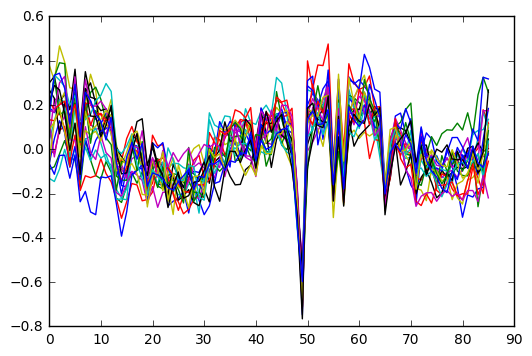

In [45]:
#plt.plot(np.arange(len(trend_and_seas[0])), trend_and_seas[cid])
for i in range(22):
    plt.plot(np.arange(len(visits[0])), visits[i])
plt.show()

In [46]:
v2015 = np.array(aggvis_2015.sort_values(by='number')['VISITS'])
v2016 = np.array(aggvis_2016.sort_values(by='number')['VISITS'])
v = np.concatenate([v2015,v2016])

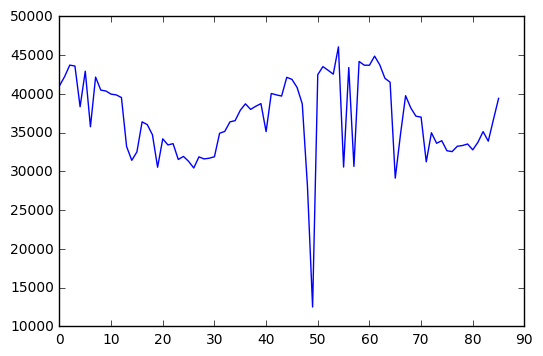

In [47]:
plt.plot(np.arange(len(v)), v)
plt.show()

In [48]:
l3 = ['2015-05-03','2015-05-17',3]
l2 = ['2016-05-08','2016-05-15',2]

l1 = ['2015-03-01', '2015-03-15','2015-06-14','2015-11-08','2016-06-19']

ll = [l2,l3]

In [49]:
a1 = ['2015-12-27']
a2 = ['2016-01-03']
a3 = ['2016-01-10']
a4 = ['2016-02-28']
a5 = ['2016-03-13']
lanom = [a1,a2,a3,a4,a5]

l3 = ['2015-05-03','2015-05-10','2015-05-17']
l2 = ['2016-05-08','2016-05-15']
l4 = ['2016-02-21','2016-02-28']
l1 = ['2015-03-01', '2015-03-15','2015-06-14','2015-11-08','2016-03-13','2016-06-19']
lny = ['2015-12-27','2016-01-03','2016-01-10']
l60 = ['2016-05-08','2016-05-15']
ll = [l2,l3,lny,l60,l4]

In [50]:
aggregated = data.groupby(by='SUNDAY_DATE').sum().sort_values(by='number').ix[:,['VISITS','number']]
aggregated['number'] = map(int, aggregated['number']/22)
aggregated.head()

,VISITS,number
SUNDAY_DATE,,
2015-02-01,2.419370,0
2015-02-08,3.378274,1
2015-02-15,4.109165,2
2015-02-22,4.051503,3
2015-03-01,1.005215,4


l3 = ['2015-05-03','2015-05-17',3]
l2 = ['2016-05-08','2016-05-15',2]
l4 = ['2016-02-21','2016-02-28',2]
l1 = ['2015-03-01', '2015-03-15','2015-06-14','2015-11-08','2016-03-13','2016-06-19']
lny = ['2015-12-27','2016-01-10',3]
l60 = ['2016-05-08','2016-05-15',2]

ll = [l2,l3,lny,l60,l4]


#l2 = ['2016-05-08','2016-05-15',2]
#l1 = ['2016-03-13','2016-06-19']
#l60 = ['2016-05-08','2016-05-15',2]

#ll = ['2015-03-01','2015-03-15','2015-05-03','2015-05-10','2015-05-17','2015-06-14','2015-11-08','2015-12-27',
#      '2016-01-03','2016-01-10','2016-02-21','2016-02-28','2016-03-13','2016-05-08','2016-05-15','2016-06-19']

In [51]:
data_rep = data.copy()

In [25]:
for inst in l1:
    to_replace = list(data.ix[data_rep['SUNDAY_DATE']==inst,:].index)
    for i in to_replace:
        data_rep.ix[i,'VISITS'] = (data_rep.ix[i-1,'VISITS'] + data_rep.ix[i+1,'VISITS'])/2

from sklearn.linear_model import Ridge

import autograd.numpy as np
from autograd import grad 
from hyperopt import fmin,tpe,space_eval,hp

for n,date in enumerate(ll):
    if n==0:
        arr = data['SUNDAY_DATE'] == date
    else:
        arr = np.any([data['SUNDAY_DATE'] == date,arr],axis=0)
for i in range(len(data)):
    if arr[i] == True:
        #проводим прямую через 3 предыдущих, чтобы заполнить аномалию
        reg = Ridge(alpha=0.1)
        try:
            X = [[data_rep.ix[i-2,'VISITS'],data_rep.ix[i-3,'VISITS'],data_rep.ix[i-4,'VISITS'],data_rep.ix[i-5,'VISITS']],
                 [data_rep.ix[i-3,'VISITS'],data_rep.ix[i-4,'VISITS'],data_rep.ix[i-5,'VISITS'],data_rep.ix[i-6,'VISITS']]]
            y = [data_rep.ix[i-1,'VISITS'],data_rep.ix[i-2,'VISITS']]
            a = True
        except:
            X = [[data_rep.ix[i-2,'VISITS'],data_rep.ix[i-3,'VISITS']],
                 [data_rep.ix[i-3,'VISITS'],data_rep.ix[i-4,'VISITS']]]
            y = [data_rep.ix[i-1,'VISITS'],data_rep.ix[i-2,'VISITS']]
            a = False
        X = np.array(X)
        y = np.array(y).reshape((len(y),1))
        reg.fit(X=X,y=y)
        if a:
            data_rep.ix[i,'VISITS'] = reg.predict([[data_rep.ix[i-1,'VISITS'],data_rep.ix[i-2,'VISITS'],data_rep.ix[i-3,'VISITS'],data_rep.ix[i-4,'VISITS']]])[0]
        else:
            data_rep.ix[i,'VISITS'] = reg.predict([[data_rep.ix[i-1,'VISITS'],data_rep.ix[i-2,'VISITS']]])[0]

for n,date in enumerate(ll):
    if n==0:
        arr = data['SUNDAY_DATE'] == date
    else:
        arr = np.any([data['SUNDAY_DATE'] == date,arr],axis=0)
for i in range(len(data)):
    if arr[i] == True:
        #проводим прямую через 3 предыдущих, чтобы заполнить аномалию
        try:
            prval = np.array(map( lambda j: data_rep.ix[i-j,'VISITS'], np.arange(1,12)))
            def loss (l):
                a,b,c,d = l
                return np.sum((np.array(map(lambda x: a*np.sin(b*x+c)+d, np.arange(1,12)))-prval[::-1])**2)
        except:
            prval = np.array(map( lambda j: data_rep.ix[i-j,'VISITS'], np.arange(1,5)))
            def loss (l):
                a,b,c,d = l
                return np.sum((np.array(map(lambda x: a*np.sin(b*x+c)+d, np.arange(1,5)))-prval[::-1])**2)
        params = [1,2,3,4]
        delta = 0.05
        step = 0.1
        for i in range(600):
            for j in range(len(params)):
                b = params[:]
                b[j] += delta
                params[j] -= step*(loss(b)-loss(params))/delta
        a,b,c,d = params
        print (params)
        data_rep.ix[i,'VISITS'] = a*np.sin(-b+c)+d

In [26]:
for inter in ll:
    start = np.array(aggvis.ix[aggvis['SUNDAY_DATE'] == inter[0],'number'])[0]
    end = np.array(aggvis.ix[aggvis['SUNDAY_DATE'] == inter[1],'number'])[0]
    length = inter[2]
    for ind in set(data['CLINIC_ID']):
        for i in range(length):
            beval = np.array(data.ix[ np.all([ np.array(data['number'] == start-1), np.array(data['CLINIC_ID'] == ind)], axis=0), 'VISITS'])[0]
            enval = np.array(data.ix[ np.all([ np.array(data['number'] == end+1), np.array(data['CLINIC_ID'] == ind)], axis=0), 'VISITS'])[0]
            data_rep.ix[ np.all([ np.array(data['number'] == start+i), np.array(data['CLINIC_ID'] == ind)], axis=0), 'VISITS'] =  ((length+1 - i)*beval + (i+1)*enval)/(length+2)

In [87]:
data = data_rep.copy()

In [88]:
for i in set(data['number']):
    buff = data.ix[data['number']==i,'VISITS']
    data.ix[data['number']==i,'VISITS'] = buff - np.mean(buff)
    data.ix[data['number']==i,'season'] = np.mean(buff)

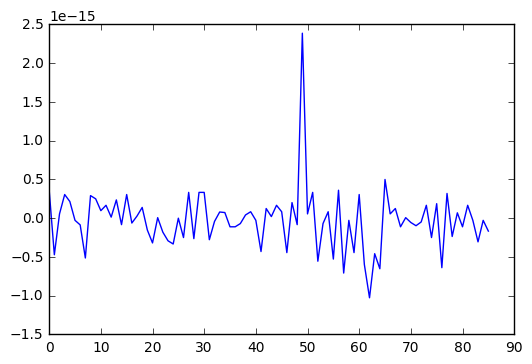

In [89]:
aggregated = data.groupby(by='SUNDAY_DATE').sum().sort_values(by='number').ix[:,['VISITS','number']]
aggregated['number'] = map(int, aggregated['number']/22)

plt.plot(aggregated['number'], aggregated['VISITS'])
plt.show()

In [90]:
visits = np.zeros(dtype='float32',shape=(22,len(set(data['number']))))
for i in np.sort(list(set(data['CLINIC_ID']))):
    arr = np.array(data.ix[data['CLINIC_ID']==i, ['number','VISITS']], dtype='float32')
    for j in range(np.shape(arr)[0]):
        visits[i-1,int(arr[j,0])] = arr[j,1].copy()
        #CLINIC_ID начинаются с единицы!!

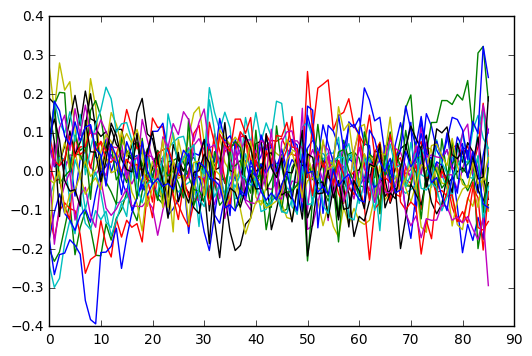

In [91]:
for i in range(22):
    plt.plot(np.arange(len(visits[0])), visits[i])
plt.show()

In [92]:
data.to_csv('prediction_processed.csv')

In [93]:
all_anom = [x for x in np.concatenate(ll) if '-' in x]

In [94]:
all_anom

['2016-05-08', '2016-05-15', '2015-05-03', '2015-05-17']

In [95]:
for i,anom in enumerate(all_anom):
    for n in range(len(data)):
        if data.ix[n,'SUNDAY_DATE'] in anom:
            data.ix[n,'anom_type'] = int(i)

In [96]:
#data = data.ix[data['number'] >= 5,:]
data = data.drop(['year','month','day'],axis=1)
data['number'] = map(int, data['number'])

sdata = pd.DataFrame()
for cid in set(data['CLINIC_ID']):
    cc = data.ix[data['CLINIC_ID'] == cid, :]
    cc = cc.sort_values(by='number')
    cc.reset_index(inplace=True,drop=True)
    shift = cc.copy()
    for i in range(1,1):
        cc.reset_index(inplace=True,drop=True)
        cc = cc.ix[1:,:].copy()
        cc.reset_index(inplace=True,drop=True)
        cc['V-' + str(i)] = shift['VISITS'].copy()
        ######shift['is_anom'] = data['anom_type'].copy()
        #for j in all_anom:
        #    shift['is_anom'] = np.any([shift['is_anom'],shift['SUNDAY_DATE'] == j], axis=0)
        #cc['V-' + str(i)+' anomaly?'] = shift['is_anom'].copy()
        cc['V-' + str(i)+' anomaly?'] = shift['anom_type'].copy()
    sdata = pd.concat([sdata,cc.copy()],axis=0)

In [97]:
data = sdata.copy()

In [98]:
data.reset_index(inplace=True,drop=True)

In [99]:
[x for x in data.columns if '?' in x]

[]

In [100]:
for i in [x for x in data.columns if '?' in x] + ['anom_type']:
    data.ix[:,i].fillna(-1,inplace=True)

In [101]:
data = pd.get_dummies(columns=[x for x in data.columns if ('anomaly?' in x)] + ['anom_type'],data=data,drop_first=True)

In [102]:
data.columns

Index([u'CLINIC_ID', u'SUNDAY_DATE', u'RECEIPTS', u'CHRONICS', u'PATIENTS',
       u'VISITS', u'DISTRICT', u'number', u'mean', u'season', u'anom_type_0.0',
       u'anom_type_1.0', u'anom_type_2.0', u'anom_type_3.0'],
      dtype='object')

In [103]:
data = pd.get_dummies(data, columns=['DISTRICT'],drop_first=True)

In [104]:
data = data.reset_index(drop=True)

In [105]:
data.drop(['SUNDAY_DATE','RECEIPTS','CHRONICS','PATIENTS'],axis=1,inplace=True)

In [106]:
data['month_number'] = map(lambda x : int(x/4)%12, data['number'])

In [107]:
data = pd.get_dummies(data,columns=['month_number'],drop_first=True)

In [108]:
#data.drop(['number'],axis=1, inplace=True)

In [109]:
from random import sample

In [110]:
test_ids = sample(population=data.index, k = len(data)/20)

In [111]:
data.to_csv('med_full_data.csv')

In [85]:
data.drop(test_ids).to_csv('ready_for_panel.csv')
data.ix[test_ids].to_csv('medtest.csv')

In [112]:
data.head()

,CLINIC_ID,VISITS,number,mean,season,anom_type_0.0,anom_type_1.0,anom_type_2.0,anom_type_3.0,DISTRICT_2,...,month_number_2,month_number_3,month_number_4,month_number_5,month_number_6,month_number_7,month_number_8,month_number_9,month_number_10,month_number_11
0,1,0.078851,0,2012.660645,0.109971,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0.011975,1,2012.660645,0.153558,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0.024865,2,2012.660645,0.186780,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0.013513,3,2012.660645,0.184159,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0.038329,4,2012.660645,0.045692,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
for n,i in enumerate(list(all_anom)):
    if n==0:
        arr = np.array(data.ix[:,'SUNDAY_DATE'] == i)
    else:
        arr = np.any(np.array([arr, np.array(data.ix[:,'SUNDAY_DATE'] == i)]), axis=0)
anom_indexes = list(data.ix[arr,'SUNDAY_DATE'].index)

In [36]:
data.drop(['SUNDAY_DATE','CLINIC_ID'],inplace=True,axis=1)
data_wo_anom = data.drop(anom_indexes)
data_anom = data.ix[anom_indexes,:]

In [37]:
data_wo_anom.head()

,RECEIPTS,CHRONICS,PATIENTS,VISITS,V-1,V-1 anomaly?,V-2,V-2 anomaly?,V-3,V-3 anomaly?,...,V-7 anomaly?,V-8,V-8 anomaly?,V-9,V-9 anomaly?,DISTRICT_1,DISTRICT_2,DISTRICT_3,DISTRICT_4,DISTRICT_5
2,2380.535326,5580.212955,68584.161413,2056.143912,2248.627230,True,2209.735048,True,2257.182686,True,...,False,2450.818623,False,2407.695020,False,0,1,0,0,0
3,2380.535326,5580.212955,68584.161413,2043.019338,2056.143912,False,2248.627230,True,2209.735048,True,...,False,2286.761439,False,2450.818623,False,0,1,0,0,0
4,2341.140993,5807.992608,68997.141201,1815.214220,2043.019338,False,2056.143912,False,2248.627230,True,...,False,2243.637836,False,2286.761439,False,0,1,0,0,0
6,2341.140993,5807.992608,68997.141201,1843.338308,1836.420764,True,1815.214220,False,2043.019338,False,...,True,2155.515692,False,2340.197207,False,0,1,0,0,0
7,2341.140993,5807.992608,68997.141201,1881.774563,1843.338308,False,1836.420764,True,1815.214220,False,...,True,2257.182686,True,2155.515692,False,0,1,0,0,0


In [38]:
X = np.array(data_wo_anom.drop('VISITS',axis=1),dtype='float32')
y = np.array(data_wo_anom['VISITS'],dtype='float32')

In [39]:
np.std(y,axis=0)

586.55286

In [40]:
X = X - np.mean(X,axis=0)
y = y - np.mean(y,axis=0)
X = X/np.std(X,axis=0)
y = y/np.std(y,axis=0)

In [41]:
np.shape(X)

(1298, 26)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07, random_state=42)

In [43]:
import keras
from keras.layers import Dense,Dropout,Input,merge,BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.regularizers import l2,l1

Using Theano backend.


In [70]:
inp = Input(shape=(np.shape(X)[1],))

l1 = Dense(60)(inp)
act1 = PReLU()(l1)
do1 = Dropout(0.35)(act1)

bn1 = BatchNormalization()(do1)
l2 = Dense(30)(bn1)
act2 = PReLU()(l2)
do2 = Dropout(0.2)(act2)

l3 = Dense(10)(do2)
act3 = PReLU()(l3)
do3 = Dropout(0.1)(act3)

me = merge([inp,do3],mode='concat')
out = Dense(1)(do3)

model = Model(input=inp,output=out)

In [53]:
inp = Input(shape=(np.shape(X)[1],))

la1 = Dense(60)(inp)
act1 = PReLU()(la1)
do1 = Dropout(0.3)(act1)

bn1 = BatchNormalization()(do1)
la2 = Dense(30,W_regularizer=l1(0.05))(bn1)
act2 = PReLU()(la2)

bn2 = BatchNormalization()(act2)
la3 = Dense(10,W_regularizer=l2(0.07))(bn2)
act3 = PReLU()(la3)

me = merge([inp,act3],mode='concat')
out = Dense(1)(me)

model = Model(input=inp,output=out)

In [54]:
model.compile(loss='mae',optimizer='sgd')

In [55]:
model.fit(batch_size=300,nb_epoch=650,verbose=2,x=X,y=y,validation_split=0.07)

Train on 1207 samples, validate on 91 samples
Epoch 1/650
0s - loss: 13.5976 - val_loss: 0.8785
Epoch 2/650
0s - loss: 13.3188 - val_loss: 0.8590
Epoch 3/650
0s - loss: 13.0450 - val_loss: 0.8296
Epoch 4/650
0s - loss: 12.7438 - val_loss: 0.7873
Epoch 5/650
0s - loss: 12.4835 - val_loss: 0.7562
Epoch 6/650
0s - loss: 12.2084 - val_loss: 0.7281
Epoch 7/650
0s - loss: 11.9395 - val_loss: 0.6959
Epoch 8/650
0s - loss: 11.6957 - val_loss: 0.6547
Epoch 9/650
0s - loss: 11.4330 - val_loss: 0.6361
Epoch 10/650
0s - loss: 11.1818 - val_loss: 0.6064
Epoch 11/650
0s - loss: 10.9346 - val_loss: 0.5680
Epoch 12/650
0s - loss: 10.6883 - val_loss: 0.5554
Epoch 13/650
0s - loss: 10.4453 - val_loss: 0.5230
Epoch 14/650
0s - loss: 10.2161 - val_loss: 0.4876
Epoch 15/650
0s - loss: 9.9871 - val_loss: 0.4599
Epoch 16/650
0s - loss: 9.7772 - val_loss: 0.4176
Epoch 17/650
0s - loss: 9.5645 - val_loss: 0.3955
Epoch 18/650
0s - loss: 9.3344 - val_loss: 0.3867
Epoch 19/650
0s - loss: 9.1293 - val_loss: 0.3589

In [52]:
model.fit(batch_size=300,nb_epoch=650,verbose=2,x=X_train,y=y_train)

Epoch 1/650
0s - loss: 1.9238
Epoch 2/650
0s - loss: 1.6648
Epoch 3/650
0s - loss: 1.4771
Epoch 4/650
0s - loss: 1.3318
Epoch 5/650
0s - loss: 1.1835
Epoch 6/650
0s - loss: 1.0757
Epoch 7/650
0s - loss: 0.9666
Epoch 8/650
0s - loss: 0.9073
Epoch 9/650
0s - loss: 0.8194
Epoch 10/650
0s - loss: 0.7690
Epoch 11/650
0s - loss: 0.7175
Epoch 12/650
0s - loss: 0.6767
Epoch 13/650
0s - loss: 0.6327
Epoch 14/650
0s - loss: 0.5919
Epoch 15/650
0s - loss: 0.5698
Epoch 16/650
0s - loss: 0.5237
Epoch 17/650
0s - loss: 0.5012
Epoch 18/650
0s - loss: 0.4769
Epoch 19/650
0s - loss: 0.4442
Epoch 20/650
0s - loss: 0.4277
Epoch 21/650
0s - loss: 0.4045
Epoch 22/650
0s - loss: 0.3965
Epoch 23/650
0s - loss: 0.3835
Epoch 24/650
0s - loss: 0.3732
Epoch 25/650
0s - loss: 0.3606
Epoch 26/650
0s - loss: 0.3560
Epoch 27/650
0s - loss: 0.3417
Epoch 28/650
0s - loss: 0.3273
Epoch 29/650
0s - loss: 0.3213
Epoch 30/650
0s - loss: 0.3178
Epoch 31/650
0s - loss: 0.3099
Epoch 32/650
0s - loss: 0.3037
Epoch 33/650
0s -

In [53]:
preds = model.predict(X_test,batch_size=300)

In [55]:
'123'

'123'

In [60]:
preds = preds.reshape(len(preds))